# SWMM Simulated Streamflow in Fall Creek, NY

Input files for the HBV, SWMM, and TOPMODEL case studies are available [here](https://drive.google.com/drive/folders/1p96I1m88nDhiwVyOoEX0ywuL5g0oBNuk?usp=sharing). To run the below scripts, copy these files into the input folder within the directory of the case study. Note: The figures generated from our workflow have generic axis labels for adaptability and use across dissimilar hydrologic modeling applications. This jupyter notebook will also re-create some of the published figures from the JAWRA manuscript (figures are located in folder labeled 'JAWRA_Figures').

The Fall Creek watershed is a 325 km<sup>2</sup> basin, located near Ithaca, New York. To complete Sobol, delta, and OLS sensitivity analyses on SWMM simulated streamflow to input parameters, we employed the Saltelli sampling scheme (described in more detail in Section 3) to create 24,000 unique parameter sets. The code is available in the "Sampling.py" script. Each parameter set was run through the Storm Water Management Model (SWMM) from January 1, 2013 through June 30, 2013, and the time series of simulated streamflow was extracted. Simulated streamflow was compared to USGS stream gauge data (waterdata.usgs.gov). Six objective functions were calculated and used as model performance metrics using the R “hydroGOF” package: mean absolute error (MAE), mean error (ME), mean squared error (MSE), Nash-Sutcliff efficiency (NSE), percent bias (pbias), and root mean squared error (RMSE).

This jupyter notebook has code cells to:
1. Load data for use in R and Python scripts
2. Calculate objective function values (i.e. performance metrics)
3. Create a historical time series and magnitude percentile plots for simulated data
4. Generate a priori and a posteriori parameter distribution plots via Approximate Bayesian Computation
5. Compute Sobol first-order, Sobol second-order, Sobol total-order, delta, and OLS sensitivity indices
6. Produce portrait, scatter, and spider plots

To complete and visualize a comprehensive sensitivity analysis on the SWMM simulations, we use packages from both R and Python. This command allows us to run R scripts in the Python jupyter notebook.

In [ ]:
%load_ext rpy2.ipython

To calculate the objective functions for the SWMM simulated streamflow, we use the [hydroGOF](https://cran.r-project.org/web/packages/hydroGOF/hydroGOF.pdf) package in R. For the SWMM streamflow simulations in the Fall Creek, NY watershed, we calculate mean error, mean absolute error, mean squared error, Nase-Sutcliffe efficiency, percent bias, and root mean squared error. The objective function evaluations are saved in the "input/" folder to be loaded into the sensitivity analysis.

In [ ]:
%%R 
# this rpy2 'Rmagic' command allows to run the entire cell block as R code

# load in the R script that calculates six objective functions on SWMM model simulations versus USGS streamgage data
# # %load Calculate_Objective_Functions.R

library(dplyr)
library(hydroGOF)
library(readxl)

# load in observation, simulation, and parameter sets
obs <- read.csv("input/observation_ts.csv", header = TRUE)
  # "time_steps" row, "index" and "value" columns 
sim <- read_xlsx("input/simulation_ts.xlsx") %>%
  dplyr::select(-1)
  # "model_runs" rows, "time_steps" columns

model_runs <- nrow(sim)
time_steps <- ncol(sim)

mean_error <- array(NA, model_runs)
mean_abs_error <- array(NA, model_runs)
mean_sq_error <- array(NA, model_runs)
root_mse <- array(NA, model_runs)
p_bias <- array(NA, model_runs)
nse <- array(NA, model_runs)

for (i in 1:model_runs) {

  print(i)

  mean_error[i] <- me(sim = as.numeric(sim[i, 1:time_steps]), obs = as.numeric(obs[, 2]))
  mean_abs_error[i] <- mae(sim = as.numeric(sim[i, 1:time_steps]), obs = as.numeric(obs[, 2]))
  mean_sq_error[i] <- mse(sim = as.numeric(sim[i, 1:time_steps]), obs = as.numeric(obs[, 2]))
  root_mse[i] <- rmse(sim = as.numeric(sim[i, 1:time_steps]), obs = as.numeric(obs[, 2]))
  p_bias[i] <- pbias(sim = as.numeric(sim[i, 1:time_steps]), obs = as.numeric(obs[, 2]))
  nse[i] <- NSE(sim = as.numeric(sim[i, 1:time_steps]), obs = as.numeric(obs[, 2]))

}

OF <- as.data.frame(mean_error) %>%
  setNames("me") %>%
  dplyr:: mutate(mae = mean_abs_error,
                 mse = mean_sq_error,
                 rmse = root_mse,
                 pbias = p_bias,
                 nse = nse)

write.table(OF, "/input/OF_values.txt", sep = " ",
            row.names = FALSE, col.names = FALSE)

Now we load the model simulation data, observation/truth data, parameter sets, time stamps, and objective function values into Python as data frames using the pandas library.

In [ ]:
import pandas as pd

#sim = pd.read_excel("input/simulation_ts.xlsx", index_col = 0)
#obs = pd.read_csv("input/observation_ts.csv")
pars = pd.read_csv("input/params.csv", header = 0)
pars.columns = ['w', 'n_imperv', 'n_perv', 's_imperv', 's_perv', 'k_sat', 'per_routed', 'cmelt', 'Tb', 'A1', 'B1']
#timestamps = pd.read_csv("input/timestamps.csv")
OF = pd.read_csv("input/OF_values.csv")

### 1. Graph Observed and Modeled Output

Comprehensive sensitivity analyses require a large number of model runs. This results in overlapping plots often with thousands of time series on them. The overlapping time series of historical and simulation data provides little insight into the frequency of various model output values. The figures below show a time series of the historical data along with a frequency magnitude percentile curve. [Magnitude percentile curves](https://waterprogramming.wordpress.com/2019/02/26/magnitude-varying-sensitivity-analysis-and-visualization-part-1/) allow for interpretation of more and less frequent observation values by grouping the individual time series into percentile ranges. The majority of simulated streamflow values fall below the historical data, implying SWMM tends to underestimate streamflow, especially in higher flow (80th-100th percentile) events. The output plots saves to the "output/plots/magnitude_perc" directory.

In [ ]:
# %load Magnitude_Perc.py
#!/usr/bin/env python3

# import python libraries
import pandas as pd
import os

# back out a directory to load python functions from "Scripts" folder
org_dir_name = os.path.dirname(os.path.realpath('Magnitude_Perc.py'))
parent_dir_name = os.path.dirname(os.path.dirname(os.path.realpath('Magnitude_Perc.py')))
os.chdir(parent_dir_name + "/Scripts")

# load python functions from ‘Scripts’ folder
import magnitude_percentile_plots

# move back into case study folder
os.chdir(org_dir_name)

# load in model simulations and observation data
sim = pd.read_excel("input/simulation_ts.xlsx", index_col = 0)
obs = pd.read_csv("input/observation_ts.csv")

# create magnitude percentile plots from observation and simulation time series data
magnitude_percentile_plots.magnitude_perc_plots(sim, obs)

The cell below will generate Figure 2 in the JAWRA manuscript.

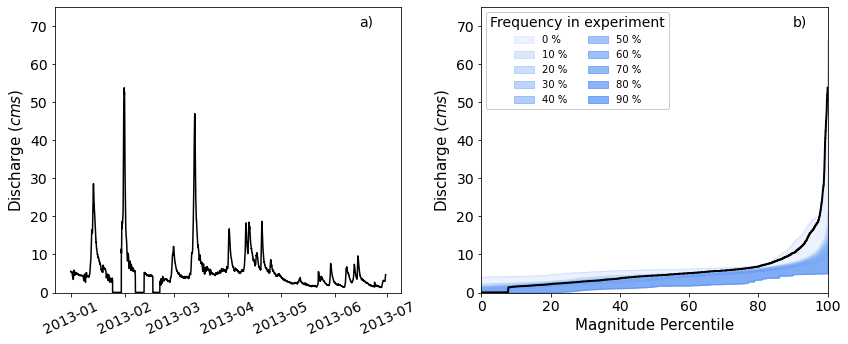

In [2]:
import jawra_manuscript_figures

jawra_manuscript_figures.magnitude_perc_plots_fig2()

### 2. Approximate Bayesian Computation
One method integrated into the workflow was Approximate Bayesian Computation (ABC), which represents the combination of model parameter values that maximize the probability of representing the observed data. ABC applies [Bayesian theory](https://en.wikipedia.org/wiki/Bayes%27_theorem) to parameter spaces to estimate posterior distributions of model parameters. ABC is advantageous because it bypasses calculating the likelihood function by using the model simulations compared to the observed data ([Engeland and Gottschalk 2002](https://www.hydrol-earth-syst-sci.net/6/883/2002/), [Kavetski et al. 2006](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005WR004368), [Sunnåker et al. 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002803), [Vrugt and Sadegh 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20354)). The steps to compute ABC are: 1) Calculate the observed data’s statistics (e.g. mean, standard deviation) and choose model specific objective functions (e.g. NSE). 2) Assume a uniform sampling interval for the parameter space. Draw a total of n parameters from prior and simulate the model for each of the parameter points, this results in n sequences of simulated data. 3) Calculate objective functions for each sequence of simulated data. 4) Determine the distance between the observed and simulated transition frequencies for all parameter points. Remove parameter points beyond a user specified tolerance interval (e.g. NSE ≥ 0.0) to approximate samples from the posterior distribution. 5) Estimate the posterior distribution with the parameter points within the tolerance interval ([Sunnåker et al. 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002803), [Vrugt and Sadegh 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20354)). 

For the python script below, specify the number of model runs, tolerance of the objective functions, number of histogram bins and the figure colors. Here we used pre-defined objective functions, but the code can be modified to calculate a variety of objective functions. The plots produced are histograms of the various parameters illustrating the difference between original modeled output and the ABC constrained parameter sets.

In [ ]:
# Move to "Scripts" Directory
import os
og_dir = os.getcwd()
root_dir = og_dir[:-4]
os.chdir(root_dir+'/Scripts')

In [ ]:
# %load approx_bayes_calc.py
#!/usr/bin/env python3
"""
Created on Mon Jul  8 12:57:45 2019

@author: catiefinkenbiner
"""
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

'''
Approximate Baysian Calculation requires:
    1) observation dataset (df_obs)
    2) parameter sets (df_parms)
    3) model output (df_model)
    4) objective functions (df_OFs)
    5) tolerance
    6) number of model runs
'''

def make_histograms(df_parms,bayes_approx,bins,alpha,cc1,cc2,parameters,metric):
    plt.figure(figsize=(12,12))
    for col in np.arange(1,((df_parms.iloc[0,:]).size)+1):
        plt.subplot(4,4,col)
        ax = df_parms.iloc[:,col-1].plot.hist(bins=bins,alpha=alpha,color=cc1,linewidth=4)    
        ax = bayes_approx.iloc[:,col-1].plot.hist(bins=bins,alpha=alpha,color=cc2,linewidth=4)
        ax.set_xlabel(str(parameters[col-1]))    
    plt.legend(['Output','ABC'],fancybox=True)
    plt.tight_layout() 
    plt.savefig('output/plots/ABC/'+metric+'_histogram.png',dpi=1000)

def make_cdfs_pdfs(df_parms,bayes_approx,bins,alpha,cc1,cc2,parameters,metric):
    plt.figure(figsize=(12,12))
    for col in np.arange(1,((df_parms.iloc[0,:]).size)+1):
        plt.subplot(4,4,col)
        ax = df_parms.iloc[:,col-1].plot.hist(cumulative=True, density=1,bins=bins,alpha=alpha,color=cc1,linewidth=4)    
        ax = bayes_approx.iloc[:,col-1].plot.hist(cumulative=True, density=1,bins=bins,alpha=alpha,color=cc2,linewidth=4)
        ax.set_xlabel(str(parameters[col-1]))    
    plt.legend(['Output','ABC'],fancybox=True)
    plt.tight_layout() 
    plt.savefig('output/plots/ABC/'+metric+'_cdf.png',dpi=1000)
    
    plt.figure(figsize=(12,12))
    for col in np.arange(1,((df_parms.iloc[0,:]).size)+1):
        plt.subplot(4,4,col)
        ax = df_parms.iloc[:,col-1].plot.kde(alpha=alpha,color=cc1,linewidth=4)    
        ax = bayes_approx.iloc[:,col-1].plot.kde(alpha=alpha,color=cc2,linewidth=4)
        ax.set_xlabel(str(parameters[col-1]))   
    plt.legend(['Output','ABC'],fancybox=True)
    plt.tight_layout() 
    plt.savefig('output/plots/ABC/'+metric+'_pdf.png',dpi=1000)

def runABC(df_parms,df_OFs,runs,bins,color1,color2):
    # models with objective functions within tolerance thresholds
    results = np.array(approx_bayes_calc_OF(df_parms,df_OFs,runs))
    
    ofs = list(df_OFs.columns.values)
    parameters = list(df_parms.columns.values)
    
    # saves models with objective functions within tolerance thresholds
    for i in np.arange(len(results)):
        bayes_approx_of = pd.DataFrame(results[i],columns=None)
        bayes_approx_of.to_csv('output/bayes_parameters_'+str(ofs[i])+'.csv',index=False)
    
        # print ABC results and make figures
        print('precent of models with '+str(ofs[i])+', tolerance = '+str(tolerances[i])+':',str(len(results[i])/runs),'%')
        make_histograms(df_parms,bayes_approx_of,bins,0.5,colors[0],colors[i+1],parameters,ofs[i])
        make_cdfs_pdfs(df_parms,bayes_approx_of,bins,0.5,colors[0],colors[i+1],parameters,ofs[i])

You will need to specify specific tolerances for the user specific objective functions. Please update the code below to fit your application.

In [ ]:
os.chdir(og_dir)

# Specify tolerance for objective functions (OF) - this needs to be updated for user specific applications.
# Here we have specified 3 OFs.
tolerance_of1 = 6.0   # OF (RMSE) < tolerance
tolerance_of2 = 15.0 # -tolerance (p-bias) < OF > tolerance (p-bias)
tolerance_of3 = 0.0  # OF >= tolerance (NSE)
tolerances = [tolerance_of1,tolerance_of2,tolerance_of3]

def approx_bayes_calc_OF(parms,OFs,simulations):
    keep_of1 = []; keep_of2 = []; keep_of3 = []
    for i in np.arange((simulations)):
        # User can redefine tolerances and OF here
        if tolerance_of1 < OFs.iloc[i,0]:
            keep_of1.append(parms.loc[i])
            
        if tolerance_of2 > np.absolute(OFs.iloc[i,1]):
            keep_of2.append(parms.loc[i])
            
        if tolerance_of3 <= OFs.iloc[i,2] :
            keep_of3.append(parms.loc[i])        

    return keep_of1,keep_of2,keep_of3

runs = 24000 # specify number of model runs
bins = 100   # specify number of histogram bins
color1 = 'b' # color of original model output
color2 = 'k' # color of 1st ABC applied to OF (RMSE)
color3 = 'r' # color of 2nd ABC applied to OF (p-bias)
color4 = 'g' # color of 3rd ABC applied to OF (NSE)
colors = [color1,color2,color3,color4]

# Runs function that evaluates models outputs with approximate Bayesian computation
runABC(pars, OF.iloc[:,3:], runs, bins, color1, color2)

The cell below will generate Figure 3 in the JAWRA manuscript.

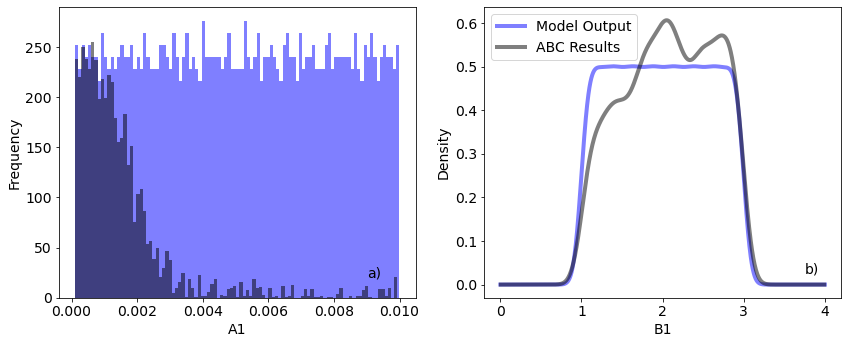

In [1]:
import jawra_manuscript_figures

jawra_manuscript_figures.ABC_plots_fig3()

### 3. Sensitivity Analysis
Three sensitivity analyses are incorporated into the workflow: a variance-based sensitivity analysis, a moment-independent sensitivity analysis, and an ordinary least squares regression. The Sobol method ([Sobol, 2001](https://doi.org/10.1016/S0378-4754(00)00270-6)) is a variance-based global sensitivity analysis that yielded first-order, second-order, and total-order sensitivity indices. Sobol’s method can effectively handle nonlinear responses and measures the effects of interactions within non-additive systems. It decomposes the variance of the model output into fractions which can be attributed to inputs or sets of inputs. The first-order sensitivity index (i.e. main effect index) quantifies parameter impact on model output variance by averaging over the variations in other input parameters. The second-order sensitivity index decomposes model variance by parameter interactions with one another. The total-order sensitivity index (i.e. total effect index) measures the contribution each parameter had on model output across the first-order index and all higher-order indices. Our workflow employs the Saltelli scheme ([Saltelli, 2002](https://doi.org/10.1016/S0010-4655(02)00280-1); [Saltelli et al., 2010](https://doi.org/10.1016/j.cpc.2009.09.018)), which allows for the calculation of the first-order, second-order, and total-order sensitivity indices with fewer model runs than a traditional approach. However, since the calculation of Sobol second-order indices requires N * (2K + 2) model runs (where N is preset model runs and K is number of parameters), some models may be too computationally expensive to run with multiple input parameters. Consequently, we included two additional sensitivity analyses which have no minimum number of model runs.

The Delta index ([Borgonovo, 2007](https://doi.org/10.1016/j.ress.2006.04.015); [Borgonovo et al., 2012](https://www.sciencedirect.com/science/article/pii/S1364815211001617?via%3Dihub); [Plischke et al., 2013](https://doi.org/10.1016/j.ejor.2012.11.047)) is a moment-independent global sensitivity analysis. While less robust than indices returned by a variance-based sensitivity analysis, a moment-independent sensitivity analysis was a popular technique due to its computational efficiency and insensitivity to dependent parameters ([Pannell, 1997](https://doi.org/10.1016/S0169-5150(96)01217-0)). The Delta sensitivity analysis searches for parameters with the greatest impact on the probability density function of model output. Delta indices capture non-linear and non-monotonic parameter-output dynamics. Lastly, the ordinary least squares (OLS) regression yields an R2 coefficient, which quantified the linear effects of model input parameters on model output variance. OLS regressions have long been employed throughout model sensitivity analyses and assume an explicit interaction between model output and any given parameter ([Kleijnen, 1995](https://doi.org/10.1002/sdr.4260110403); [Pannell, 1997](https://doi.org/10.1016/S0169-5150(96)01217-0); [Zobitz et al., 2006](https://doi.org/10.1016/j.agrformet.2006.01.003)).

To visualize objective function sensitivity to model input parameters, the following code produces radial convergence plots, scatter plots, portrait plots, and spider plots based on the outputs from the sensitivity analyses.

The Sobol and delta sensitivity indices are calculated using a modified version of the Python sensitivity analysis library ([SALib](https://salib.readthedocs.io/en/latest/index.html)) and the OLS regression is calculated using [StatsModels](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) library in Python.

In [ ]:
# %load SensIndices_RCPlots.py
#!/usr/bin/env python3

# import python libraries
import pandas as pd
import os

# back out a directory to load python functions from "Scripts" folder
org_dir_name = os.path.dirname(os.path.realpath('SensIndices_RCPlots.py'))
parent_dir_name = os.path.dirname(os.path.dirname(os.path.realpath('SensIndices_RCPlots.py')))
os.chdir(parent_dir_name + "/Scripts")

# load python functions from ‘Scripts’ folder
import delta
import sobol
import ols
import radial_conv_plots

# move back into case study 0 folder
os.chdir(org_dir_name)

# Define the model inputs
problem = {
    'num_vars': 11,
    'names': ['w', 'n_imperv', 'n_perv', 's_imperv', 's_perv', 'k_sat', 'per_routed', 'cmelt', 'Tb', 'A1', 'B1'],
    'bounds': [[500, 1500], # meters
               [0.01, 0.2],
               [0.01, 0.2],
               [0, 10],
               [0, 10],
               [0.01, 10],
               [0, 100],
               [0, 4],
               [-3, 3],
               [0.0001, 0.01],
               [1, 3]]
}

# load in model parameter sets (Saltelli sampled) and objective function values
pars = pd.read_csv("input/params.csv", header = 0)
OF = pd.read_csv("input/OF_values.csv")

# save the parameter names
param_names = problem['names']

# calculate Sobol first-, second-, and total order indices --> MUST BE BASED ON SALTELLI SAMPLING SCHEME
results_SI = []
results_SI = sobol.objective_function_sobol(problem, OF)

# create radial convergence plots based on results_SI
radial_conv_plots.radial_conv_plots(problem, results_SI, OF)

# calculate delta indices and sobol first-order indices
results_delta = []
results_delta = delta.objective_function_delta(problem, pars, OF)

# calculate R^2 from OLS regression
results_R2 = []
results_R2 = ols.objective_function_OLS(OF, pars, param_names)

From the sensitivity analysis results (calculated and exported from python), we can create portrait plots, scatter plots, and spider plots for various objective functions and parameter values.

First, the data is loaded and formatted into a usable format and then exported to a .csv file. Then the script creates additional plots to help visualize and convey parameter sensitivity.

In [ ]:
%%R
# %load Portrait_Scatter_Spider.R

library(dplyr)

# load in objective function values and parameter sets
pars <- read.csv("input/params.csv", header = TRUE)
  # "model_runs" rows, "num_pars" columns

OF <- read.csv("input/OF_values.csv", header = TRUE)
  # "model_runs" rows, "num_OF" columns

# save names of objective functions and parameters
OF_names <- colnames(OF)
param_names <- colnames(pars)

# set variables of number of model runs, time steps, and number of parameters
model_runs <- nrow(pars)
num_pars <- ncol(pars)
num_OF <- ncol(OF)

# load in results from delta, sobol, and ols sensitivity analyses (calculated in python script)
source("../Scripts/python_to_r_results.R")
results_sobol <- python_to_r_results(data_type = "sobol", param_names, OF_names)
results_delta <- python_to_r_results(data_type = "delta", param_names, OF_names)
results_ols <- python_to_r_results(data_type = "ols", param_names, OF_names)

# save as csv files
lapply(results_sobol, function(x) write.table(data.frame(x), 'output/formatted_sobol.csv', append = T, sep = ',' ))
lapply(results_delta, function(x) write.table(data.frame(x), 'output/formatted_delta.csv', append = T, sep = ',' ))
lapply(results_ols, function(x) write.table(data.frame(x), 'output/formatted_ols.csv', append = T, sep = ',' ))

# scatter plots of objective functions versus parameter values
source("../Scripts/scatterplots.R")
for (i in 1:num_OF) {
  
  # subset by objective function, i
  objective_fun <- OF[, i]

  # create scatterplots of all parameters versus objective function, i
  par_OF_scatter(params = pars, objective_fun, OF_name = colnames(OF)[i])
  
}

# portrait plots of objective functions versus parameter values
source("../Scripts/portrait_plots.R")
portrait_plot(results_sobol, "sobol")
portrait_plot(results_delta, "delta")
portrait_plot(results_ols, "ols")

# spiders plots of objective functions versus parameter values
source("../Scripts/spider_plots.R")
spiderplot(results_sobol)
spiderplot(results_delta)
spiderplot(results_ols)

### 4. Inference of Results

ABC was implemented with a tolerance specified at NSE ≥ 0.0 and the results from the workflow were visualized as histograms, CDFs and pdfs. The histograms illustrate the frequency distributions of parameter sets constrained by ABC specified tolerances (Figure 3(a)). Changing the tolerance will adjust the frequency distributions of parameters as a function of the user specified objective functions. CDFs (refer to GitHub repository) and pdfs (Figure 3(b)) provide the user with additional visualizations of the constrained parameter sets based on ABC. Based on Figure 3, the SWMM model configurations with the most positive NSE values have the A1 parameter equaling values near zero. One might conclude the A1 parameter should be sampled from a constrained range of values, skewed toward zero. Constraining A1 may adjust the histograms, CDFs and pdfs of other parameters depending on the user specified objective function and tolerance interval. However, it is impossible to conclude this without understanding the relationships and dependencies between the various parameters of the model. Additional sensitivity analyses are required to adequately describe the parameter interactions within hydrologic models.

The scatterplots of objective function value versus parameter value illustrate a linear relationship indicated by the R2 value from the OLS sensitivity analysis. For Cast Study 0, it can be inferred that the A1 and B1 groundwater coefficients have the strongest linear impacts on the objective function (i.e. NSE). The spider plots illustrate the difference in sensitivity index magnitudes across the model parameters for each objective function and sensitivity analysis. The results reinforce the OLS regression results of the A1 and B1 groundwater coefficients being the most impactful on model output.

The radial convergence plots (RCPs) were produced as a result of the Sobol sensitivity analysis. RCPs visualize not only the first-order and total-order sensitivity for each parameter but also the second-order interactions between model parameters. Large first-order indices indicate the parameter is influential over model output or the objective function. Small first-order indices indicate the parameter is unimportant in model output, which allows for model simplification. Second-order indices describe how much the interactions between two parameters influence model output, and total-order indices describe how much the sum of all parameter interactions influence model output.

The next visuals produced by the workflow are portrait plots. Portrait plots allow for the direct comparison of all objective functions and parameters for each sensitivity analysis. In the plots below, a darker shade of green indicates higher objective function sensitivity to model parameter value. While several parameters seem to have a linear impact on the objective functions in the OLS regression, for the Sobol and Delta sensitivity analyses, the A1 and B1 groundwater parameters show the most significant influence over the various objective function values.

### 5. Conclusions

The workflow is organized modularly to incorporate additional sensitivity analyses and visualization techniques. Future work could further develop the process to allow for the iteration of parameter sampling based on the results of the various sensitivity analyses.